# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 7)})
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv('games.csv')

# Предобработка данных

In [3]:
df1

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.1+ MB


In [5]:
# коррекция названий столбцов к нижнему регистру
df1.columns = [c.lower() for c in list(df1.columns)]

# коррекция регистра строк
name_list = ['name', 'platform', 'genre']
for name in name_list:
    df1[name] = df1[name].str.lower()

In [6]:
# Сумма пропусков в каждом столбце
df1.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

# Первый взгляд

Первое, что нужно сделать для дальнейшей удобной работы с данными - привести все строки к нижнему регистру. Далее в 'name' можно увидеть отсутствие названий у двух игр, предполагаю от этого можно избавится. Ещё у нас есть пропуски в дате релиза, что с этим делать придумаю позже, возможно получится заполнить пропуски. Вместе с названиями у двух игр отсутсвует и их жанр, скорее всего и дата релиза тоже. Отдельно хочу отметить много пропусков в столбцах с оценками и рейтингом игр. Дропать NA, наверное, не лучшая идея - теряем много данных.

In [7]:
# Сумма полных дубликатов 
df1.duplicated().sum()

0

In [8]:
# Дроп строк с отсутствием названия и жанра
df1.dropna(subset=['name','genre'], inplace=True)

In [9]:
# Небольшая проверка на артефакты
for unique in df1:
    print(unique)
    print(df1[unique].unique())
    print()

name
['wii sports' 'super mario bros.' 'mario kart wii' ...
 'woody woodpecker in crazy castle 5' 'lma manager 2007'
 'haitaka no psychedelica']

platform
['wii' 'nes' 'gb' 'ds' 'x360' 'ps3' 'ps2' 'snes' 'gba' 'ps4' '3ds' 'n64'
 'ps' 'xb' 'pc' '2600' 'psp' 'xone' 'wiiu' 'gc' 'gen' 'dc' 'psv' 'sat'
 'scd' 'ws' 'ng' 'tg16' '3do' 'gg' 'pcfx']

year_of_release
[2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]

genre
['sports' 'platform' 'racing' 'role-playing' 'puzzle' 'misc' 'shooter'
 'simulation' 'action' 'fighting' 'adventure' 'strategy']

na_sales
[4.136e+01 2.908e+01 1.568e+01 1.561e+01 1.127e+01 2.320e+01 1.128e+01
 1.396e+01 1.444e+01 2.693e+01 9.050e+00 9.710e+00 9.000e+00 8.920e+00
 1.500e+01 9.010e+00 7.020e+00 9.430e+00 1.278e+01 4.740e+00 6.380e+00
 1.083e+01 9.540e+00 9.660e+00 8.410e+00 6.060e+0

In [10]:
# Сколько % составляют данные с неопределённым рейтингом от пользователей?
len(df1.query('user_score == "tbd"')) / len(df1)

0.14503679770238737

In [11]:
# Замена tbd на более удобный NaN
tbd = df1['user_score'] != 'tbd'
df1['user_score'].where(tbd, np.nan, inplace=True)
df1['user_score'] = df1['user_score'].astype('float')

# user_score: tbd
TBD - абревиатура, обычно обозначает не сформированный рейтинг по разным причинам, например: мало оценок от пользователей. На metacritic нужно как минимум 4 оценки от пользователей, чтобы значение tbd сменилось на рейтинг. В нашем датасете tbd составляет 15 процентов. Возможно tbd лучше скорректировать как NaN и привести данные к типу float

In [12]:
# Попытка заполнить пропущенные значения в дате релиза
for i in df1[df1.year_of_release.isnull() == True].index:  
    df1.year_of_release[i] = df1.loc[df1.name == df1.name[i], 'year_of_release'].max()

df1['year_of_release'] = df1['year_of_release'].astype('Int64')
df1['year_of_release'].isna().sum()

146

# year_of_release и NaN
Получилось заполнить пропуски в некоторых строках с помощью цикла, который ищет совпадающие названия игры и заполняет пропуски в дате релиза. Сейчас колличество NaN-ов в year_of_release позволяет двигаться дальше. Хотя их колличество и раньше это позволяло, но почему бы не заполнить если это можно сделать! =)

In [13]:
# Приводим к нужным типам данных
df1['critic_score'] = df1['critic_score'].astype('Int64')

In [14]:
df1.isna().sum() / len(df1)

name               0.000000
platform           0.000000
year_of_release    0.008736
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513133
user_score         0.545863
rating             0.404715
dtype: float64

# Вывод по предобработке

Пропуски, которые было возможно заполнить - заполнены. Осталось много NaN-ов в оценках и рейтинге игр, 50% - это ого, но с этим можно работать =) На мой вгляд их лучше оставить незаполнеными, сейчас данные правдивые, но если их постараться заполнить средним или медианой, то реультаты анализа будут неэфективны.

# Сколько игр выпускалось в разные годы?

In [15]:
# Сумируем прибыль по всем регионам в один столбец
df1['total_sales'] = df1.loc[:,['na_sales', 'eu_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [16]:
# Создаем сводную таблицу с колличеством выпущенных игр по годам
game_release_count = df1.pivot_table(index=['year_of_release'], values='name', aggfunc='count').sort_values('year_of_release', ascending=False)

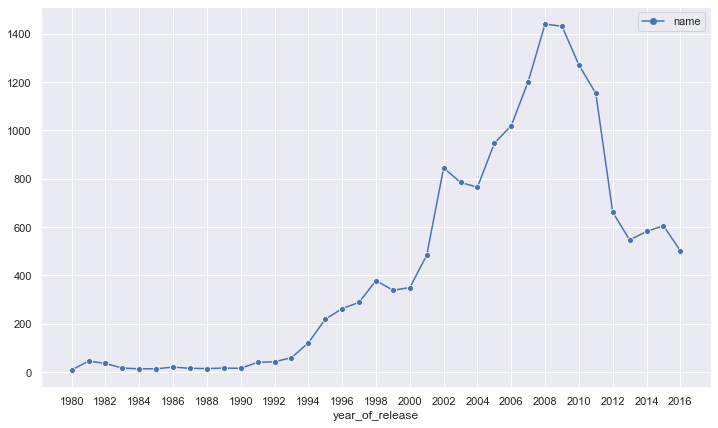

In [17]:
# Рисуем график релизов игр по годам
ax = sns.lineplot(markers=True, data=game_release_count);
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

# Данные за период

Важны ли данные за весь период продаж игр? Скорее нет, чем да. Достаточно выбрать актуальный временной период, допустим десять лет, и уже по этому отрезку смореть данные. Такое предложение можно обосновать тем, что индустрия игр меняется и то , что было актуально десять лет назад скорее всего не будет актуально сейчас, за исключением всеми любимой классики - Mario от Nintendo или Crash Bandicoot от Naughty Dog.

# Актуальность платформ

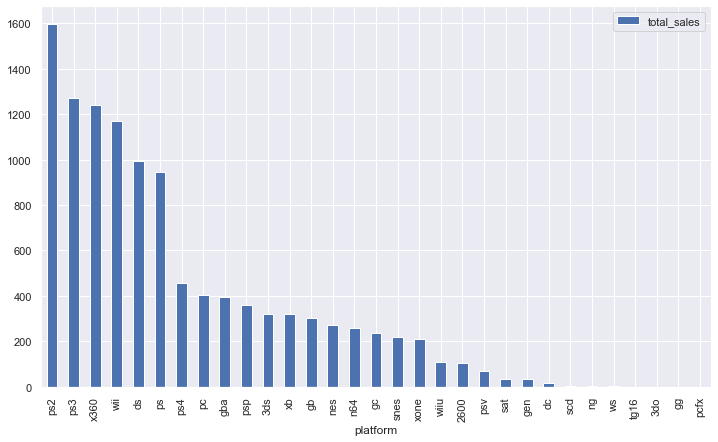

In [18]:
# График продаж игр на всех платформах
df1_sales_platform = df1.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False)
ax = df1_sales_platform.plot(kind='bar')

In [19]:
# Выбираем топ 5 платформ
df1_top5_platform = df1_sales_platform.head(5)

In [20]:
def year_total_sales(name, df):
    return (df
            .query("platform == @name")
            .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
            .sort_values('year_of_release', ascending=False)
)

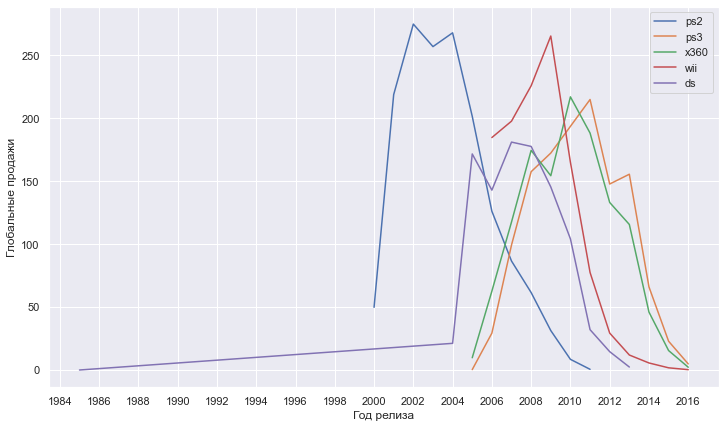

In [21]:
for platform in list(df1_top5_platform.index):
    ax = year_total_sales(platform, df1)['total_sales'].plot(label=platform)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.xlabel("Год релиза")
    plt.ylabel("Глобальные продажи")
    plt.legend()

# Актуальность платформ

Выше на графиках видно какие продажи были на всех платформах. Выделив топ 5 условно успешных платформ можно увидеть их расвет и закат. Самой популярной платформой является Sony Playstation 2, у неё самые большие продажи и у неё был большой и продолжительный пик популярности. Тоже самое можно сказать и о других платформах, у нас ведь топ пять лучших. График показывает, что платформы в основном хватает на плюс минус десять лет, что так же позволяет предполагать достаточным десятилетний период для анализа.

# Популярные платформы

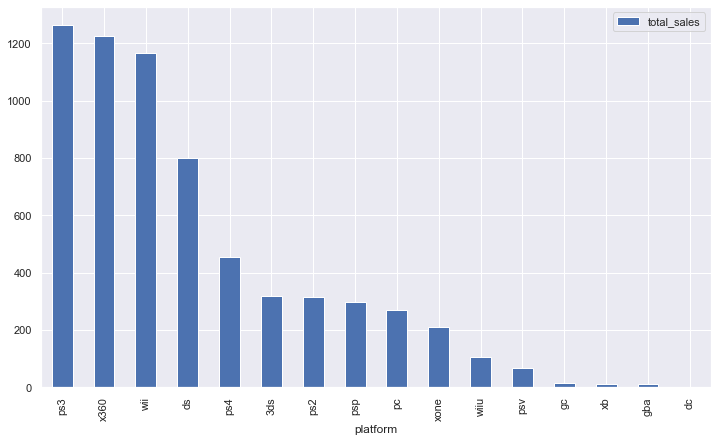

In [22]:
# График популярности платформ
df1_actualy = df1.query('year_of_release >= 2006').reset_index(drop=True)
total_sales = df1_actualy.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False)
total_sales.plot(kind='bar')
plt.show()

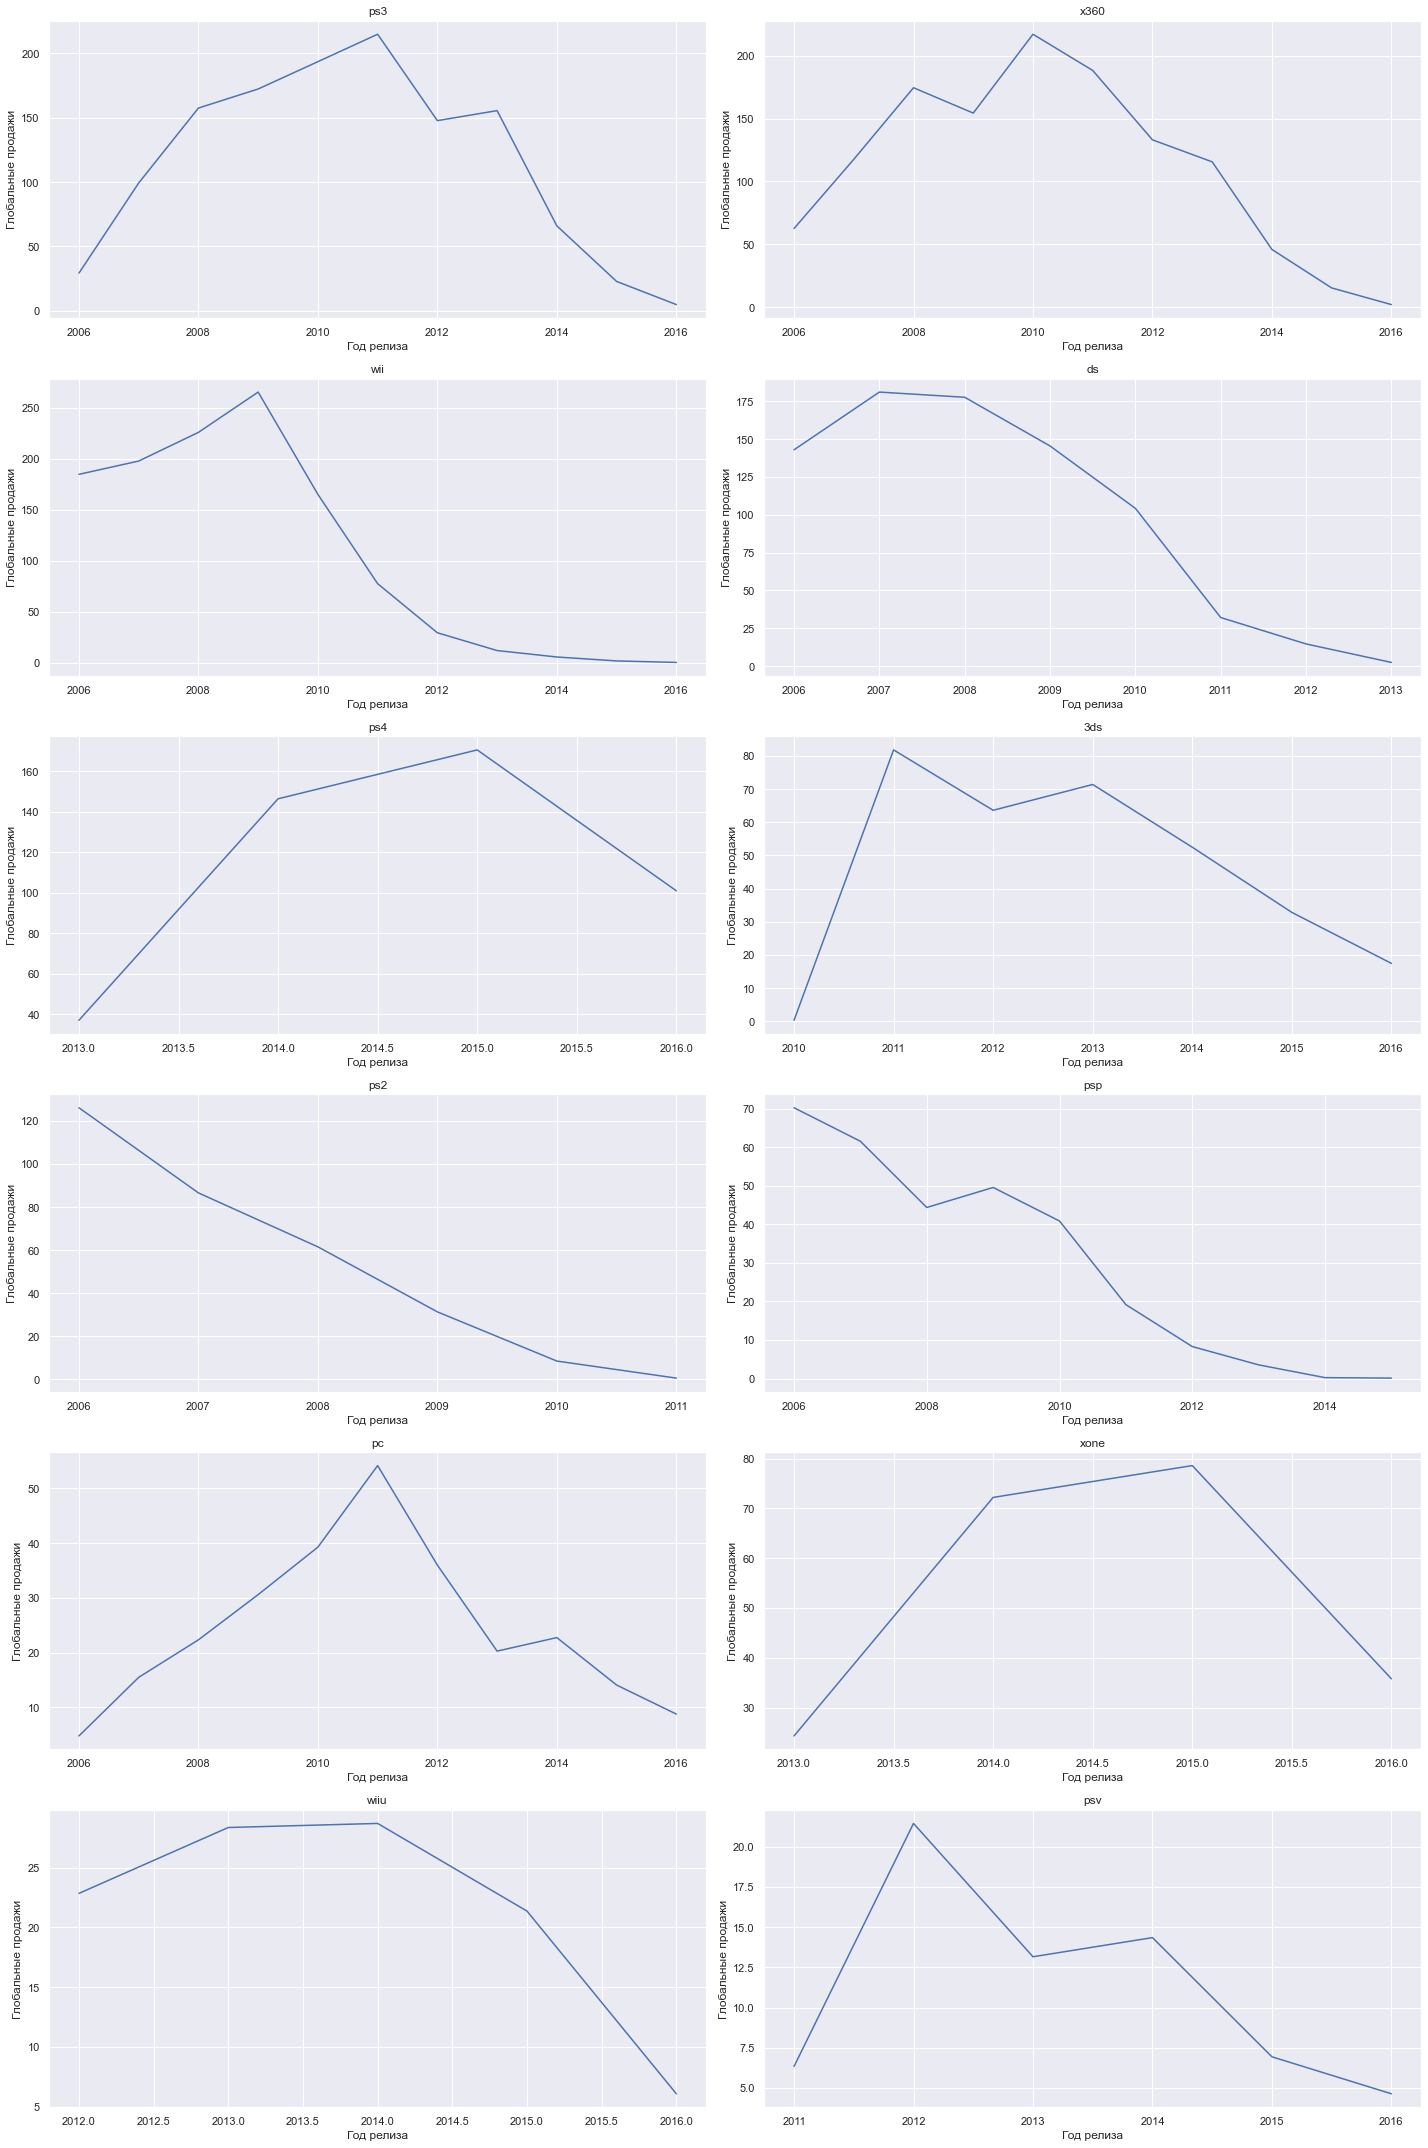

In [23]:
# Цикл для отображения графиков развития популярности платформ
platforms = list(total_sales.index)

rows = 6
count = (len(platforms) // rows)
fig, ax = plt.subplots(rows, count)

num = 0
for row in range(rows):
    for col in range(count):
        platform = platforms[num]
        (
            year_total_sales(platform, df1_actualy)['total_sales']
                .plot(ax=ax[row, col], figsize=(20, 30), title=platform)
                .set(xlabel='Год релиза', ylabel='Глобальные продажи')
)
        num += 1


plt.tight_layout()
plt.show()

# Развитие популярности платформ

На основе полученных графиков можно выделить консоли нового поколения и соответственно обозначить их как перспективные консоли для поддержки от игровых издателей. PS4 и XOne выпустились в 2013 году и на 2016-2017 год точно являются актуальными для поддержки новых игр. Можно ещё отметить платформу PC, продажи которой падают с течением времени, на мой взгляд это связанно с доступностью обхода лецинзионной защиты и распростронением не лицензионных копий игр.

# Платформы нового поколения

Среднее глобальных продаж на PS4: 113.8
Медиана глобальных продаж на PS4: 124


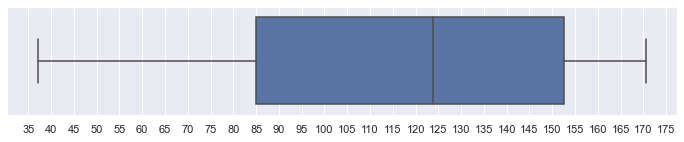

In [24]:
ps4_sales_pivot = df1_actualy.query('platform == "ps4"').pivot_table(index=['year_of_release'], values='total_sales', aggfunc='sum')

plt.figure(figsize=(12, 2));
ax = sns.boxplot(ps4_sales_pivot);
ax.xaxis.set_major_locator(ticker.MultipleLocator(5));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

print('Среднее глобальных продаж на PS4: {:.1f}'.format(ps4_sales_pivot['total_sales'].mean()))
print('Медиана глобальных продаж на PS4: {:.0f}'.format(ps4_sales_pivot['total_sales'].median()))

Среднее глобальных продаж на XONE: 52.7
Медиана глобальных продаж на XONE: 54


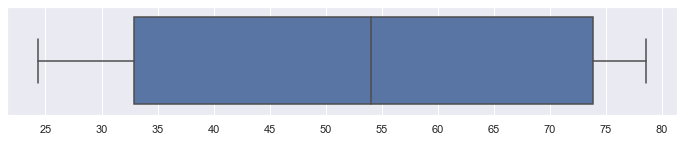

In [25]:
xone_sales_pivot = df1_actualy.query('platform == "xone"').pivot_table(index=['year_of_release'], values='total_sales', aggfunc='sum')

plt.figure(figsize=(12, 2));
ax = sns.boxplot(xone_sales_pivot);
ax.xaxis.set_major_locator(ticker.MultipleLocator(5));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

print('Среднее глобальных продаж на XONE: {:.1f}'.format(xone_sales_pivot['total_sales'].mean()))
print('Медиана глобальных продаж на XONE: {:.0f}'.format(xone_sales_pivot['total_sales'].median()))

# Усы

Можно наблюдать как сильно отличаются продажи игр на PS4 и XONE. Первая платформа превосходит по продажам вторую почти в два раза. Скорее всего такой перевес в пользу PS4 создают экслюзивы SONY.

# Как отзывы влияют на продажи?

In [26]:
# Делим на две даты с консолями
ps4 = df1_actualy.query('platform == "ps4"')
xone = df1_actualy.query('platform == "xone"')

In [27]:
# corr() не пропускал с NA. Решил отфильтровать
ps4['critic_score'] = ps4['critic_score'].fillna(-1)
ps4 = ps4.query('critic_score > -1')

xone['critic_score'] = xone['critic_score'].fillna(-1)
xone = xone.query('critic_score > -1')

In [28]:
# корреляция для группы продаж (>10)
corr_list = ['user_score', 'critic_score', 'total_sales']
print('PS 4', ps4.query('total_sales > 10')[corr_list].corr())
print()
print('XBox One', xone.query('total_sales > 10')[corr_list].corr())

PS 4               user_score  critic_score  total_sales
user_score      1.000000      0.901214     0.460309
critic_score    0.901214      1.000000     0.754191
total_sales     0.460309      0.754191     1.000000

XBox One               user_score  critic_score  total_sales
user_score           NaN           NaN          NaN
critic_score         NaN           NaN          NaN
total_sales          NaN           NaN          NaN


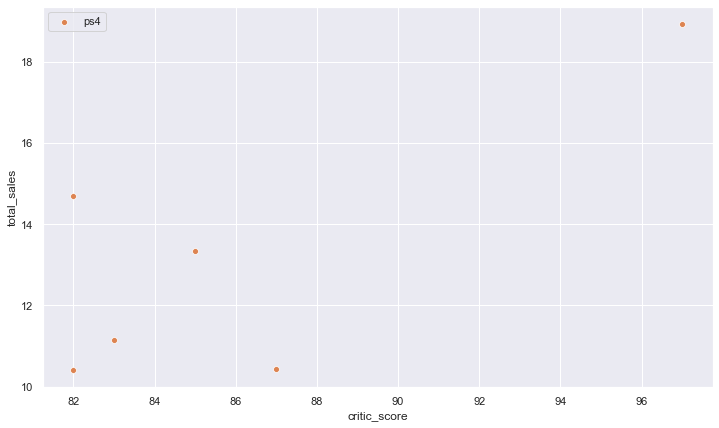

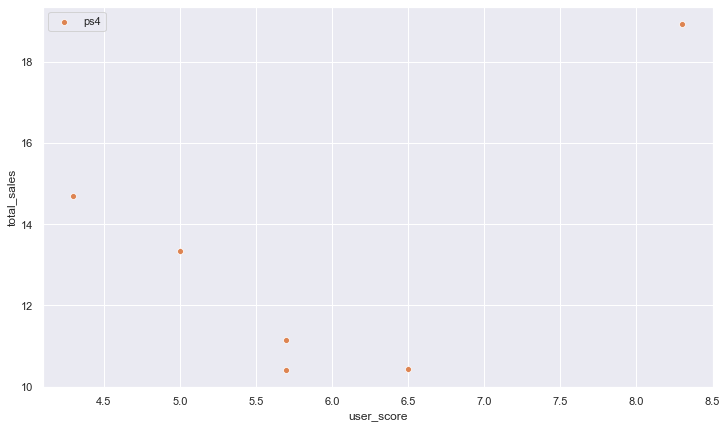

In [29]:
row = ['critic_score', 'user_score']
for i in row:
    sns.scatterplot(x=i, y="total_sales", label='xone', data=xone.query('total_sales > 10'))
    sns.scatterplot(x=i, y="total_sales", label='ps4', data=ps4.query('total_sales > 10'))
    plt.show()

In [30]:
# корреляция для группы продаж (<10)
corr_list = ['user_score', 'critic_score', 'total_sales']
print('Playstation 4', ps4.query('total_sales < 10')[corr_list].corr())
print()
print('XBox One', xone.query('total_sales < 10')[corr_list].corr())

Playstation 4               user_score  critic_score  total_sales
user_score      1.000000      0.583183     0.023097
critic_score    0.583183      1.000000     0.395547
total_sales     0.023097      0.395547     1.000000

XBox One               user_score  critic_score  total_sales
user_score      1.000000      0.472462    -0.091516
critic_score    0.472462      1.000000     0.417843
total_sales    -0.091516      0.417843     1.000000


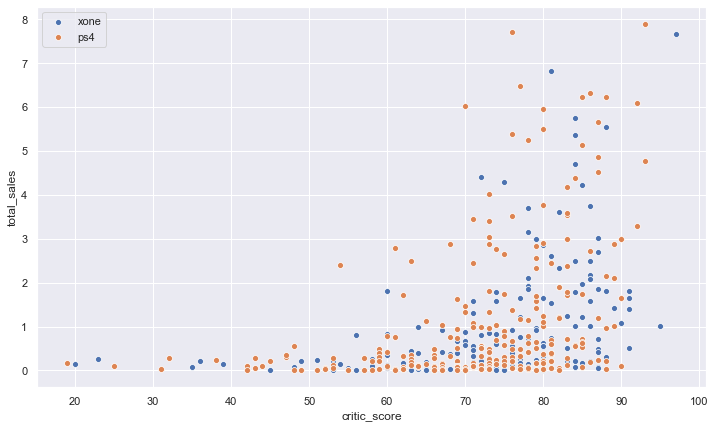

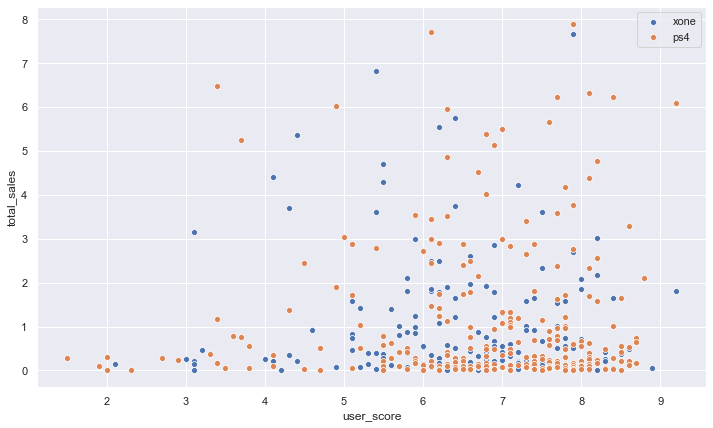

In [31]:
row = ['critic_score', 'user_score']
for i in row:
    sns.scatterplot(x=i, y="total_sales", label='xone', data=xone.query('total_sales < 10'))
    sns.scatterplot(x=i, y="total_sales", label='ps4', data=ps4.query('total_sales < 10'))
    plt.show()

# Влияние отзывов на продажи

Связи между оценками пользователей и глобальными продажами игр - нет. Оценки критиков, как показывает корреляция, есть, но небольшая. Скорее всего большая часть любителей игр любят просто поиграть не сильно заморачиваясь с отзывами. Но всё же пользователь больше доверяет оценке критиков, чем геймеров.</p>

И правда, если разделить продажи на две группы можно приближенней рассмотреть картину. У XBox One, например, нет продаж больше 10, а у PS4 оценки критиков сильно коррелируют с продажами. Если брать группу меньше 10, то тут уже появляется XBox One, но корреляция оценки пользователей и критиков к финальным продажам снижается и становится не существенной.

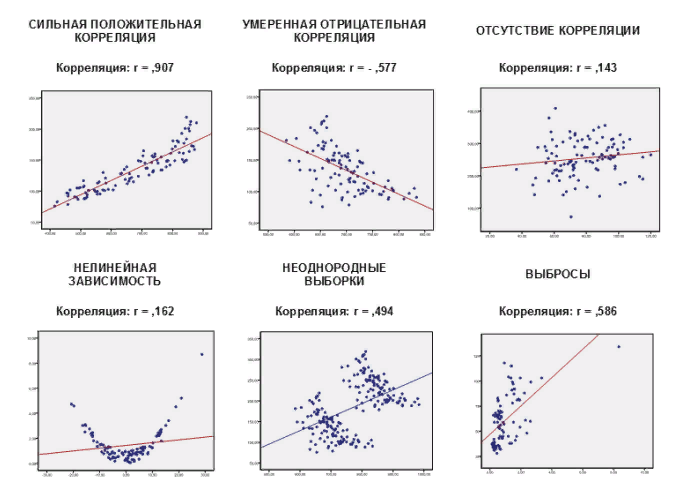

# Популярность жанров

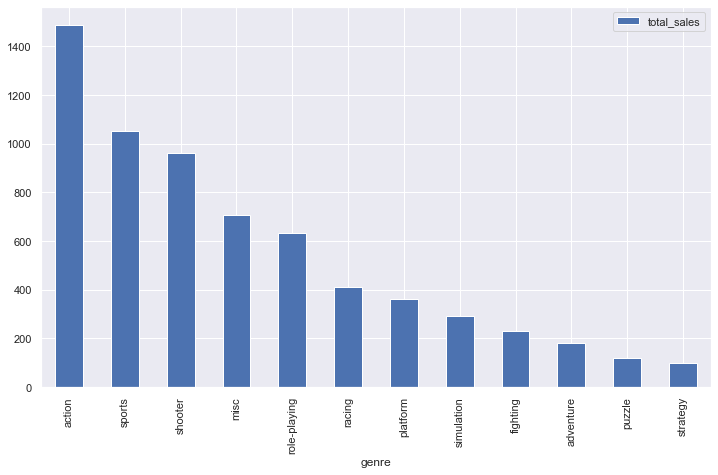

In [34]:
df1_actualy.pivot_table(index=['genre'], values='total_sales', aggfunc='sum').sort_values('total_sales', ascending=False).plot(kind='bar', y='total_sales')
plt.show()

# Популярность жанров

Самыми популярными игровыми жанрами у пользователей являются экшн, спорт и шутеры. В топ три вошли ожидаемы жанры. Хуже всего продаются стратегии, пазлы и приключения. Эта картинка по всем регионам и, например, в Японии картина может быть совсем другой.

# Самые популярные платформы (топ-5) NA, EU, JP

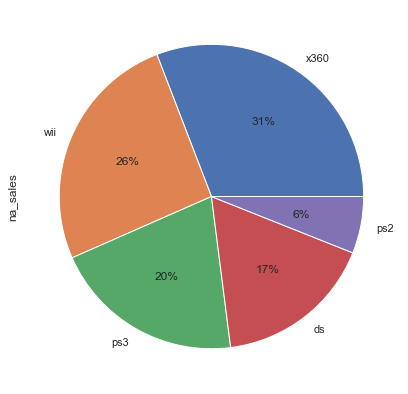

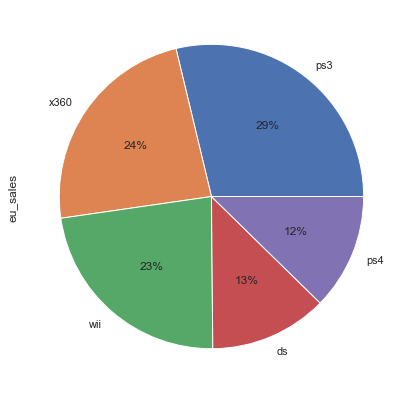

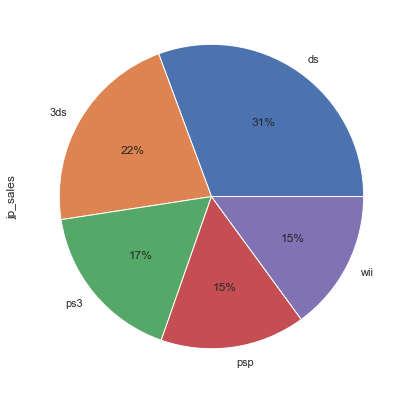

In [35]:
region_list = ['na_sales', 'eu_sales', 'jp_sales']
for region in region_list:
    (df1_actualy
     .pivot_table(index='platform', values=region, aggfunc='sum')
     .sort_values(region, ascending=False).head(5)
     .plot(kind='pie', y=region, autopct='%1.0f%%', legend=False)
)

# Самые популярные платформы (топ-5) NA, EU, JP

North America (NA) - Xbox 360 от Microsoft лидирует по продажам в этом регионе, Microsoft старается удерживать потребителя в домашнем регионе и у неё это получается, несмотря на отсутствие экслюзивов. На втором месте консоль от Nintendo, которая обгоняет Playstation 3 - её доля составляет 20% рынка и позволяет занять третью позицию. Наименьшую долю рынка занимает Playstation 2 от Sony, справедливо, ведь на смену ей пришла ps3, а затем ps4

Europe (EU) - В Европе другая картина. С небольшим отрывом в  5% лидирует Playstation 3 от Sony, Xbox 360 находится на второй позиции с 24% рынка. Последнюю позицию занимает Playstation 4, этой консоли можно дать скидку - она увидела свет совсем недавно и скорее всего ещё не все пользователи обновились. А вот Xbox One здесь не видно.

Japan (JP) - Япония отдаёт предпочтение портативным платформам. На этом рынке лидирует Nintendo, целых три консоли от них занимают рынок. 2 из 5 позиции занимают Sony с портативной PSP и стационарной Playstation 3.

# Самые популярные жанры (топ-5) NA, EU, JP

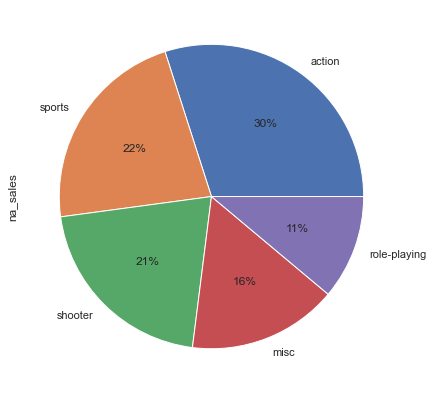

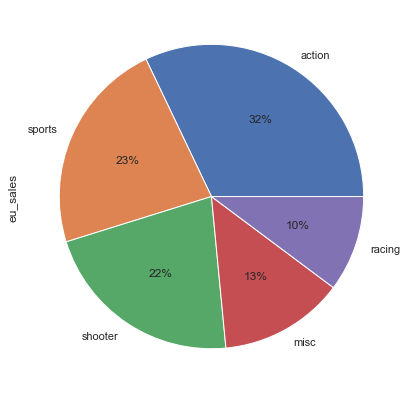

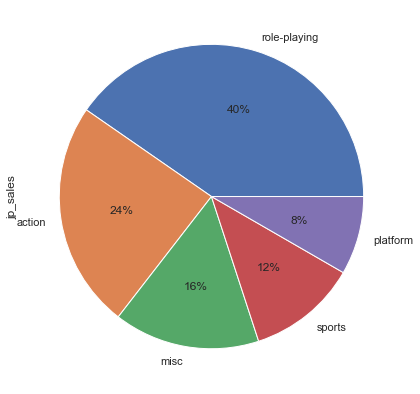

In [36]:
region_list = ['na_sales', 'eu_sales', 'jp_sales']
for region in region_list:
    (df1_actualy
     .pivot_table(index='genre', values=region, aggfunc='sum')
     .sort_values(region, ascending=False).head(5)
     .plot(kind='pie', y=region, autopct='%1.0f%%', legend=False)
)

# Самые популярные жанры (топ-5) NA, EU, JP

North America (NA), Europe (EU) - В тройке жанровых лидеров занимающие большую часть рынка - Экшн, спорт и шутеры.


Japan (JP) - В JP картина отличается от EU и NA. Здесь игроки предпочитат Role Play, при чем этот жанр занимает целых 40% рынка. Это позволяет сказать, что JP очень любит RPG, очень. Вторую позицию занимает экшн.

# Влияет ли рейтинг ESRB на продажи в отдельном регионе?

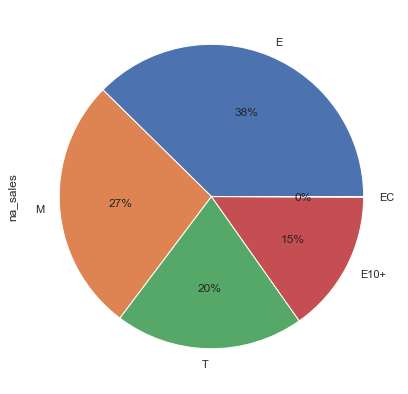

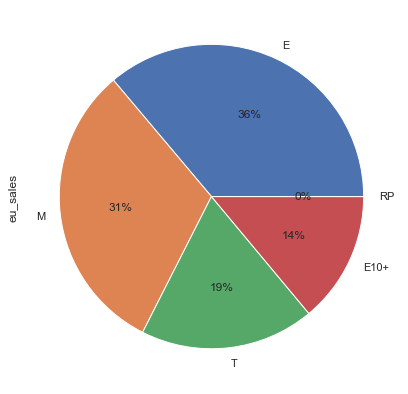

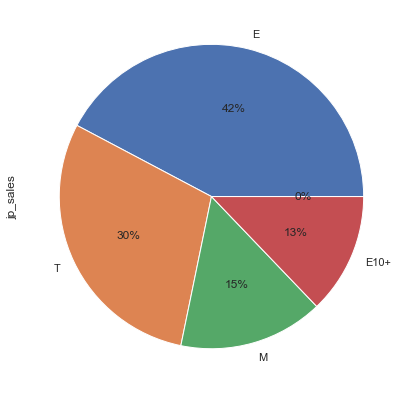

In [37]:
region_list = ['na_sales', 'eu_sales', 'jp_sales']
for region in region_list:
    (df1_actualy
     .pivot_table(index='rating', values=region, aggfunc='sum')
     .sort_values(region, ascending=False).head(5)
     .plot(kind='pie', y=region, autopct='%1.0f%%', legend=False)
)

# Влияет ли рейтинг ESRB на продажи в отдельном регионе?</h3></strong>

Во всех регионах издатели стараются удержать аудиторию не достигших 18+ возраста, это видно на графиках. В топ 5 не входит рейтинг Adult Only(Ao).

# Проверка гипотез

Распределение данных в user score

Нулевая гипотеза (H₀) - будет означать, что данные распределены равномерно

Альтернативная гипотеза (H₁) - будет означать, что данные распределены не равномерно

In [38]:
stat, pvalue = st.shapiro(df1_actualy.query('platform == ["pc", "xone"]')['user_score'].dropna())

alpha = 0.05

print('Статистика {}, pvalue {}'.format(stat, pvalue))

if pvalue > alpha:
    print('Данные распределены равномерно (H₀)')
else:
    print('Данные распределены не равномерно (H₁)')

Статистика 0.93148273229599, pvalue 9.070677515594443e-19
Данные распределены не равномерно (H₁)


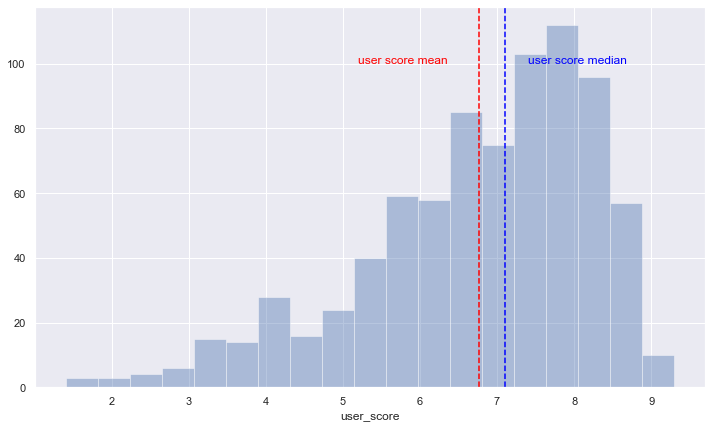

In [39]:
plt.axvline(df1_actualy.query('platform == ["pc", "xone"]')['user_score'].mean(), linestyle='--', color='red');
plt.text(x=5.2, y=100, s='user score mean', fontsize=12, color='red');
plt.axvline(df1_actualy.query('platform == ["pc", "xone"]')['user_score'].median(), linestyle='--', color='blue');
plt.text(x=7.4, y=100, s='user score median', fontsize=12, color='blue');
ax = sns.distplot(df1_actualy.query('platform == ["pc", "xone"]')['user_score'], kde=False);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter());
plt.show()

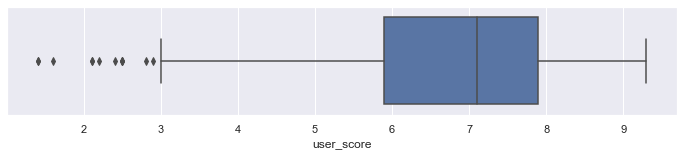

In [40]:
plt.figure(figsize=(12, 2));
ax = sns.boxplot(df1_actualy.query('platform == ["pc", "xone"]')['user_score']);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

# Распределение данных в user score

Если делать тест Шапиро-Уилка нам станет известно, что данные в user score платформ pc и xone распределены не равномерно (не по Гаусу). Это подтверждают общие графики. Гистограма показывает смещение данных в правую сторону, а ящик с усами показывает выбросы. Нужно ли их фильтровать?

# Проверка гипотез

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза (H₀) - будет означать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза (H₁) - будет означать, что средние пользовательские рейтинги платформ Xbox One и PC различаются

In [41]:
pc = df1_actualy.query('platform == "pc"')

results = st.ttest_ind(
    xone['user_score'],
    pc['user_score'],
    equal_var=False,
    nan_policy='omit'
)

alpha = .05

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги платформ Xbox One и PC различаются (H₁)")
else:
    print("Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (H₀)")

p-значение: 0.014192240358464078
Средние пользовательские рейтинги платформ Xbox One и PC различаются (H₁)


In [42]:
stat, pvalue = st.mannwhitneyu(pc['user_score'].dropna(), xone['user_score'].dropna())

alpha = 0.05

print('Статистика {}, pvalue {}'.format(stat, pvalue))

if pvalue > alpha:
    print('Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (H₀)')
else:
    print('Средние пользовательские рейтинги платформ Xbox One и PC различаются (H₁)')

Статистика 42821.5, pvalue 0.00036193390028930767
Средние пользовательские рейтинги платформ Xbox One и PC различаются (H₁)


In [43]:
pc_xone_user_score_mean = (df1_actualy
                               .query('platform == ["pc", "xone"]')
                               .pivot_table(index=['platform'], values='user_score', aggfunc=['mean', 'median', np.var, np.std])
)
pc_xone_user_score_mean.columns = ['mean', 'median', 'var', 'std']
pc_xone_user_score_mean

,mean,median,var,std
platform,,,,
pc,6.835942,7.3,2.300034,1.516586
xone,6.521429,6.8,1.906997,1.380941


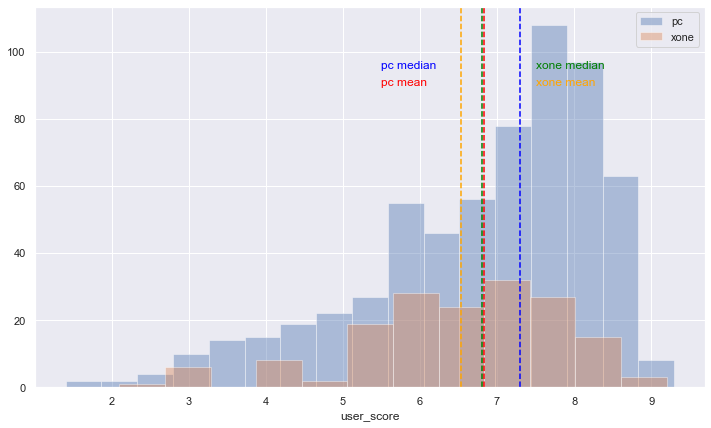

In [44]:
plt.axvline(pc['user_score'].mean(), linestyle='--', color='red');
plt.text(x=5.5, y=90, s='pc mean', fontsize=12, color='red');
plt.axvline(pc['user_score'].median(), linestyle='--', color='blue');
plt.text(x=5.5, y=95, s='pc median', fontsize=12, color='blue');
plt.axvline(xone['user_score'].mean(), linestyle='--', color='orange');
plt.text(x=7.5, y=90, s='xone mean', fontsize=12, color='orange');
plt.axvline(xone['user_score'].median(), linestyle='--', color='green');
plt.text(x=7.5, y=95, s='xone median', fontsize=12, color='green');
ax = sns.distplot(pc['user_score'], kde=False, label='pc');
ax = sns.distplot(xone['user_score'], kde=False, label='xone');
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter());
plt.legend();
plt.show()

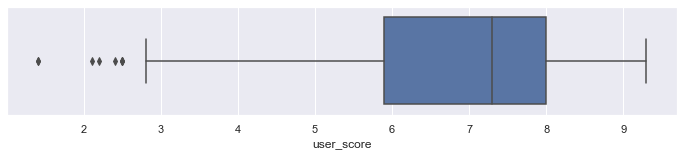

In [45]:
plt.figure(figsize=(12, 2));
ax = sns.boxplot(pc['user_score']);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

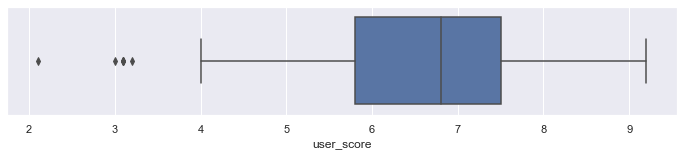

In [46]:
plt.figure(figsize=(12, 2));
ax = sns.boxplot(xone['user_score']);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

# Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

p-value = 1.4%. Довольно маленькая вероятность получить различия в рейтинге, но так как мы используем стандартное значение alpha=0.05 мы отвергаем гипотезу. Несмотря на равное среднее между двумя платформами различие в пользовательских оценках могут быть большими. В таком случае гипотеза "средние пользовательские рейтинги платформ Xbox One и PC одинаковые" не подтвердилась.

Добавил способ сравнения гипотез Маннауитни, который так же отклонил нашу гипотезу о равенстве средних user score между pc и xone. Вывел на экран дисперсию и стандартное отклонение, которое допускает большое различие от среднего user score. На графиках показано распределение данных. Гистограма опять показывает смещение данных в правую сторону и не равенство средних, а ящик с усами показывает выбросы.

# Проверка гипотез

Распределение данных в action и sports

Нулевая гипотеза (H₀) - будет означать, что данные распределены равномерно

Альтернативная гипотеза (H₁) - будет означать, что данные распределены не равномерно

In [47]:
stat, pvalue = st.shapiro(df1_actualy.query('genre == ["action", "sports"]')['user_score'].dropna())

alpha = 0.05

print('Статистика {}, pvalue {}'.format(stat, pvalue))

if pvalue > alpha:
    print('Данные распределены равномерно (H₀)')
else:
    print('Данные распределены не равномерно (H₁)')

Статистика 0.929675281047821, pvalue 7.629586521017725e-30
Данные распределены не равномерно (H₁)


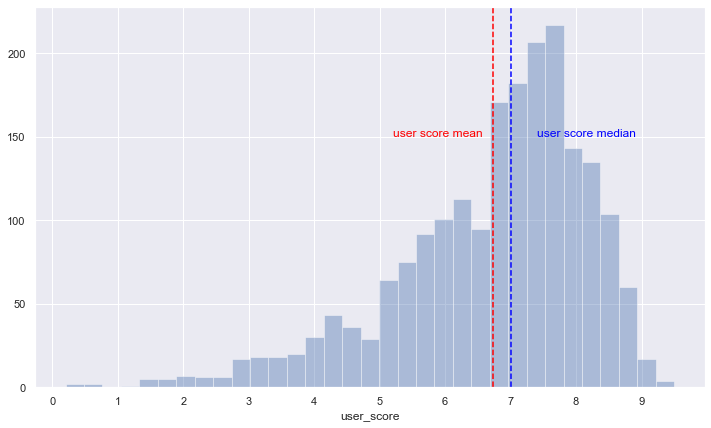

In [48]:
plt.axvline(df1_actualy.query('genre == ["action", "sports"]')['user_score'].mean(), linestyle='--', color='red');
plt.text(x=5.2, y=150, s='user score mean', fontsize=12, color='red');
plt.axvline(df1_actualy.query('genre == ["action", "sports"]')['user_score'].median(), linestyle='--', color='blue');
plt.text(x=7.4, y=150, s='user score median', fontsize=12, color='blue');
ax = sns.distplot(df1_actualy.query('genre == ["action", "sports"]')['user_score'], kde=False);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter());
plt.show()

In [1]:
plt.figure(figsize=(12, 2));
ax = sns.boxplot(df1_actualy.query('genre == ["action", "sports"]')['user_score'], showfires=False);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

NameError: name 'plt' is not defined

# Проверка гипотез

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза (H₀) - будет означать, что средние пользовательские рейтинги жанров Action и Sports одинаковые

Альтернативная гипотеза (H₁) - будет означать, что средние пользовательские рейтинги жанров Action и Sports различаются

In [50]:
action = df1_actualy.query("genre == 'action'")
sports = df1_actualy.query("genre == 'sports'")

In [51]:
results = st.ttest_ind(
    action['user_score'],
    sports['user_score'],
    nan_policy='omit'
)

alpha = .05

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, H₁")
else:
    print("Не получилось отвергнуть нулевую гипотезуб H₀")

p-значение: 2.3269301012258e-11
Отвергаем нулевую гипотезу, H₁


In [52]:
stat, pvalue = st.mannwhitneyu(action['user_score'].dropna(), sports['user_score'].dropna())

alpha = 0.05

print('Статистика {}, pvalue {}'.format(stat, pvalue))

if pvalue > alpha:
    print('Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (H₀)')
else:
    print('Средние пользовательские рейтинги платформ Xbox One и PC различаются (H₁)')

Статистика 384139.0, pvalue 1.4375298994436926e-09
Средние пользовательские рейтинги платформ Xbox One и PC различаются (H₁)


In [53]:
action_sports_user_score_mean = (df1_actualy
                               .query('genre == ["action", "sports"]')
                               .pivot_table(index=['genre'], values='user_score', aggfunc=['mean', 'median', np.var, np.std])
)
action_sports_user_score_mean.columns = ['mean', 'median', 'var', 'std']
action_sports_user_score_mean

,mean,median,var,std
genre,,,,
action,6.881013,7.2,1.849542,1.359979
sports,6.418622,6.8,2.713412,1.647244


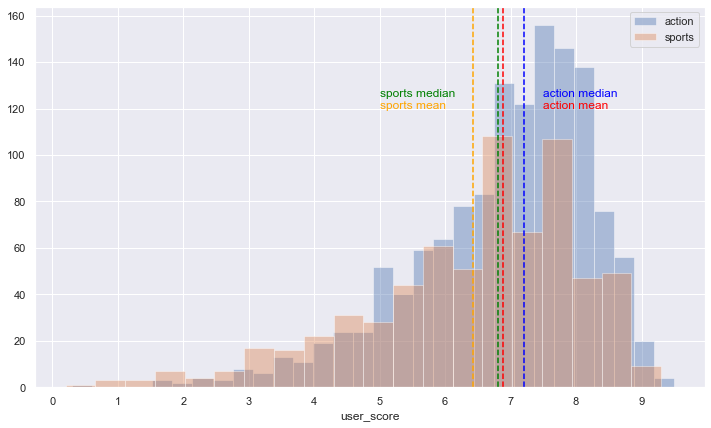

In [54]:
plt.axvline(action['user_score'].mean(), linestyle='--', color='red');
plt.text(x=7.5, y=120, s='action mean', fontsize=12, color='red');
plt.axvline(action['user_score'].median(), linestyle='--', color='blue');
plt.text(x=7.5, y=125, s='action median', fontsize=12, color='blue');
plt.axvline(sports['user_score'].mean(), linestyle='--', color='orange');
plt.text(x=5, y=120, s='sports mean', fontsize=12, color='orange');
plt.axvline(sports['user_score'].median(), linestyle='--', color='green');
plt.text(x=5, y=125, s='sports median', fontsize=12, color='green');
ax = sns.distplot(action['user_score'], kde=False, label='action');
ax = sns.distplot(sports['user_score'], kde=False, label='sports');
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter());
plt.legend();
plt.show()

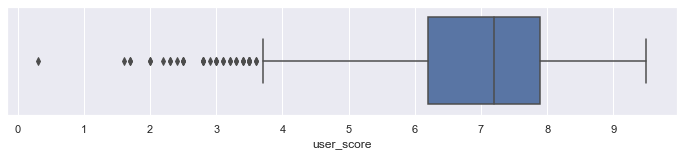

In [55]:
plt.figure(figsize=(12, 2));
ax = sns.boxplot(action['user_score']);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

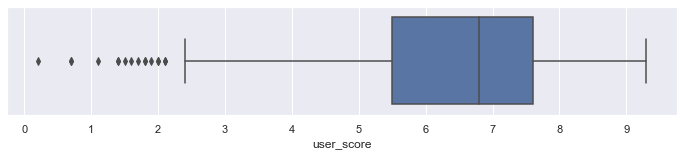

In [56]:
plt.figure(figsize=(12, 2));
ax = sns.boxplot(sports['user_score']);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

# Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Гипотеза "средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные." подтвердилась. Низкое значение p-value говорит о том, что случайно получить различия в рейтинге не получится.

Здесь так же добавил способ сравнения гипотез Маннауитни, тест Шапиро-Уилка сказал нам, что данные распределены не равномерно (не по Гаусу). Вывел на экран дисперсию и стандартное отклонение от среднего, которое допускает большое различие от среднего. На гистограме видно смещение данных в правую сторону и различие средних. Ящик с усами снова показал выбросы.

# Общий вывод

Можно выделить такие аспекты ситуации на рынке:

Временной отрезок актуальности платформ равен плюс минус десять лет;
      
На данный момент актуальными платформами являются консоли нового поколения Playstation 4 и Xbox One;

Япония – рынок отличается от остальных регионов. Спросом пользуются портативные консоли и жанр RPG;

В Европе и Америке лидируют такие жанры как: экшн, спорт и шутеры;

Значительную долю рынка занимают игры с рейтингом ниже Adult Only(Ao) и нацелены на детей и подростков.

Так же мы отклонили гипотезу о равенстве средней оценки пользователя между платформами Xbox One и PC и подтвердили гипотезу о различии средней оценки пользователя между жанрами Action и Sports.